<a href="https://colab.research.google.com/github/AlbertRoca29/EconomiaCircular/blob/main/Script_exploraci%C3%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import data and libraries

%matplotlib inline

!pip install geopandas

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Tweets comptes 
urlT = 'https://github.com/AlbertRoca29/EconomiaCircular/blob/main/Tweets.csv?raw=true'
T = pd.read_csv(urlT)

# Tweets tots
urlTAll = 'https://github.com/AlbertRoca29/EconomiaCircular/blob/main/Tweets_All.xlsx?raw=true'
T_All = pd.read_excel(urlTAll,engine='openpyxl')


In [ ]:
#@title <h5> Fix some variables 
# Datetime format
T['Date'] = pd.to_datetime(T['Date'])
T_All['Date'] = pd.to_datetime(T_All['Date'])

# Remove year 2023
T = T[(T['Date'].dt.year > 2007) & (T['Date'].dt.year < 2023)]
T_All = T_All[(T_All['Date'].dt.year > 2007) & (T_All['Date'].dt.year < 2023)]

# Index
T['Index'] = 1 + np.log(1+ T_All['Retweets'])
T_All['Index'] = 1 + np.log(1+ T_All['Retweets'])



**Dates selected** : from 01-01-2008 to 31-12-2022

**Formula for indices**: Index of the tweet ($Index$), number of retweets ($R$)

$ Index = 1 + log(1+ R) $


| Paraules | 
|:-|
Minimització de residus
Producció neta
Zero emissions / Emissions zero
Economia verda
Triple balanç
Reciclatge
Avaluació del Cicle de Vida / Anàlisi del Cicle de Vida
Consum sostenible
decreixement / Creixement zero / Zero creixement, 
Responsabilitat Social Corporativa / RSC
Responsabilitat Social Universitaria / RSU
Economia blava
Creació de valor compartit / Valor compartit
Ecologia industrial
Economia col·laborativa
Economia circular


# Anàlisi dels twits dels comptes escollits



In [21]:
#@title Grups i comptes escollits

Comptes = {
    'Diaris': ['diariARA','elnacionalcat','VilaWeb','324cat','CatalunyaRadio','rac1'],
    'Administracions Públiques': ['govern','generalitat' ,'gencat' ,'diba','DiputacioGirona' ,'DiputacioLleida' ,'Dipta_cat'],
    'Universitats': ['uabbarcelona ','uabbarcelona ','upfbarcelona ','la_upc ','univgirona ','UdL_info ','universitatURV '],
    'Patronals': ['pimec ','FomentTreball ','PatronalCecot'],
    'Sindicats': ['ccoocatalunya ','ugtcatalunya ','cgtcatalunya ','LaIntersindical'],
}

# find the maximum length of any email list
max_len = max([len(email_list) for email_list in Comptes.values()])

# pad shorter lists with empty strings
for email_list in Comptes.values():
    while len(email_list) < max_len:
        email_list.append('')

# print the group headers
for group in Comptes.keys():
    print(f"{group.capitalize():<29}", end='')
print()

# print a separator line
print("-" * (29 * len(Comptes)))

# print the emails in columns
for i in range(max_len):
    for group, email_list in Comptes.items():
        print(f"{email_list[i]:<29}", end='')
    print()




Diaris                       Administracions públiques    Universitats                 Patronals                    Sindicats                    
-------------------------------------------------------------------------------------------------------------------------------------------------
diariARA                     govern                       uabbarcelona                 pimec                        ccoocatalunya                
elnacionalcat                generalitat                  uabbarcelona                 FomentTreball                ugtcatalunya                 
VilaWeb                      gencat                       upfbarcelona                 PatronalCecot                cgtcatalunya                 
324cat                       diba                         la_upc                                                    LaIntersindical              
CatalunyaRadio               DiputacioGirona              univgirona                                                        

In [ ]:
#@title Nombre de twits (reals i seguint l'index) 2008 - Actualitat per a cada organització

T['Index'] = 1+ np.log(1+ T['Retweets'])

Tgrup = T.groupby('Grup')["Index"].agg({"size",'sum'}).rename(columns={"size": "Twits", "sum": "Twits index"}).astype({"Twits index": int}).reset_index('Grup')

Tgrup['% Twits'] = (Tgrup['Twits'] / Tgrup['Twits'].sum() * 100).round(1)
Tgrup['% Twits index'] = (Tgrup['Twits index'] / Tgrup['Twits index'].sum() * 100).round(1)

print(Tgrup.to_string(index=False))

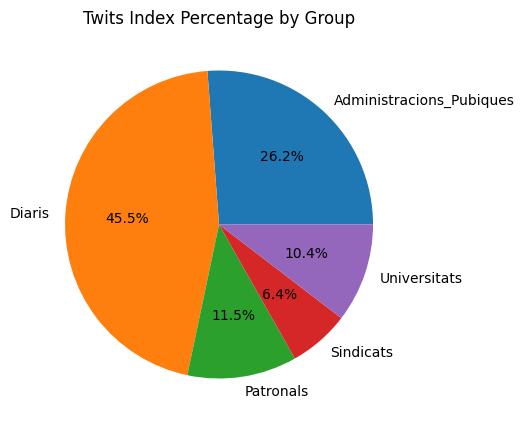

In [23]:
#@title Group Pie chart, per Twits Index

plt.figure(figsize=(5,5))
plt.pie(Tgrup['% Twits index'], labels=Tgrup['Grup'], autopct='%1.1f%%')
plt.title('Twits Index Percentage by Group')
plt.show()


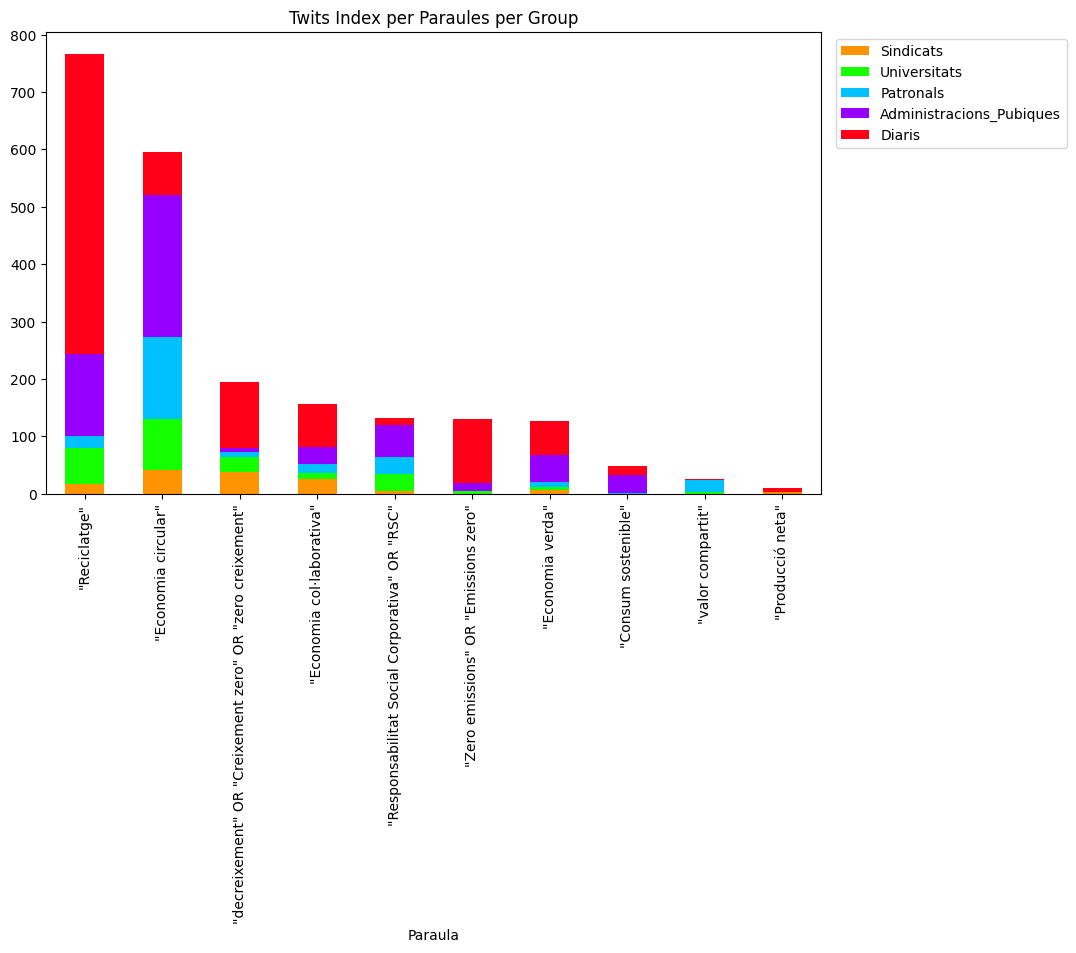

In [24]:
#@title Paraules Bar Plot, per Twits Index

plt.figure(figsize=(10,6))
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0.1, 1, len(np.unique(T['Grup']))))

bot = T.groupby(['Paraula','Grup'])['Index'].sum().groupby('Paraula').sum()

ind = np.argsort(bot)[::-1]

bot = bot[ind]-bot[ind]

zero = bot.copy()

plt.title('Twits Index per Paraules per Group')

for i, grup in enumerate(list(T['Grup'].value_counts().sort_values().keys())):
    T_p = T[T['Grup']==grup]
    Pr = ((zero + T_p.groupby('Paraula')['Index'].sum())[ind]).fillna(0)
    Pr.plot(kind='bar',color=colors[i],label=grup,bottom=bot)
    bot += Pr
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()


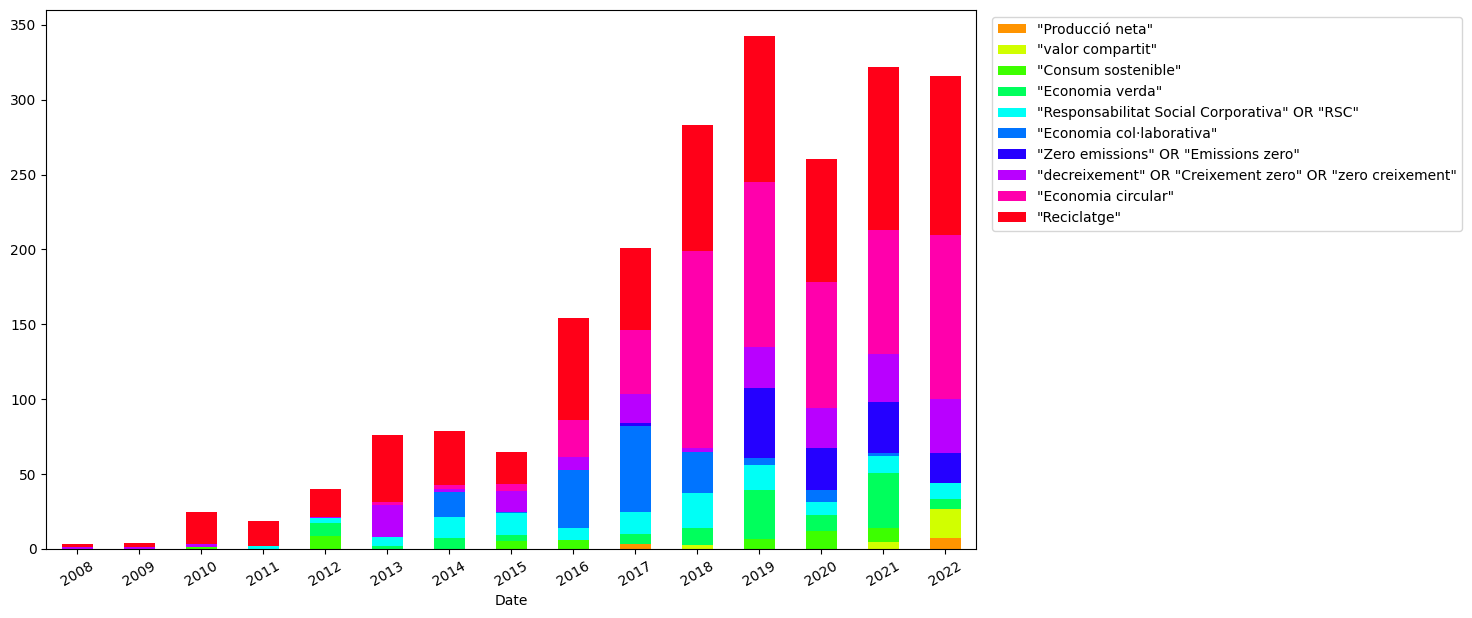

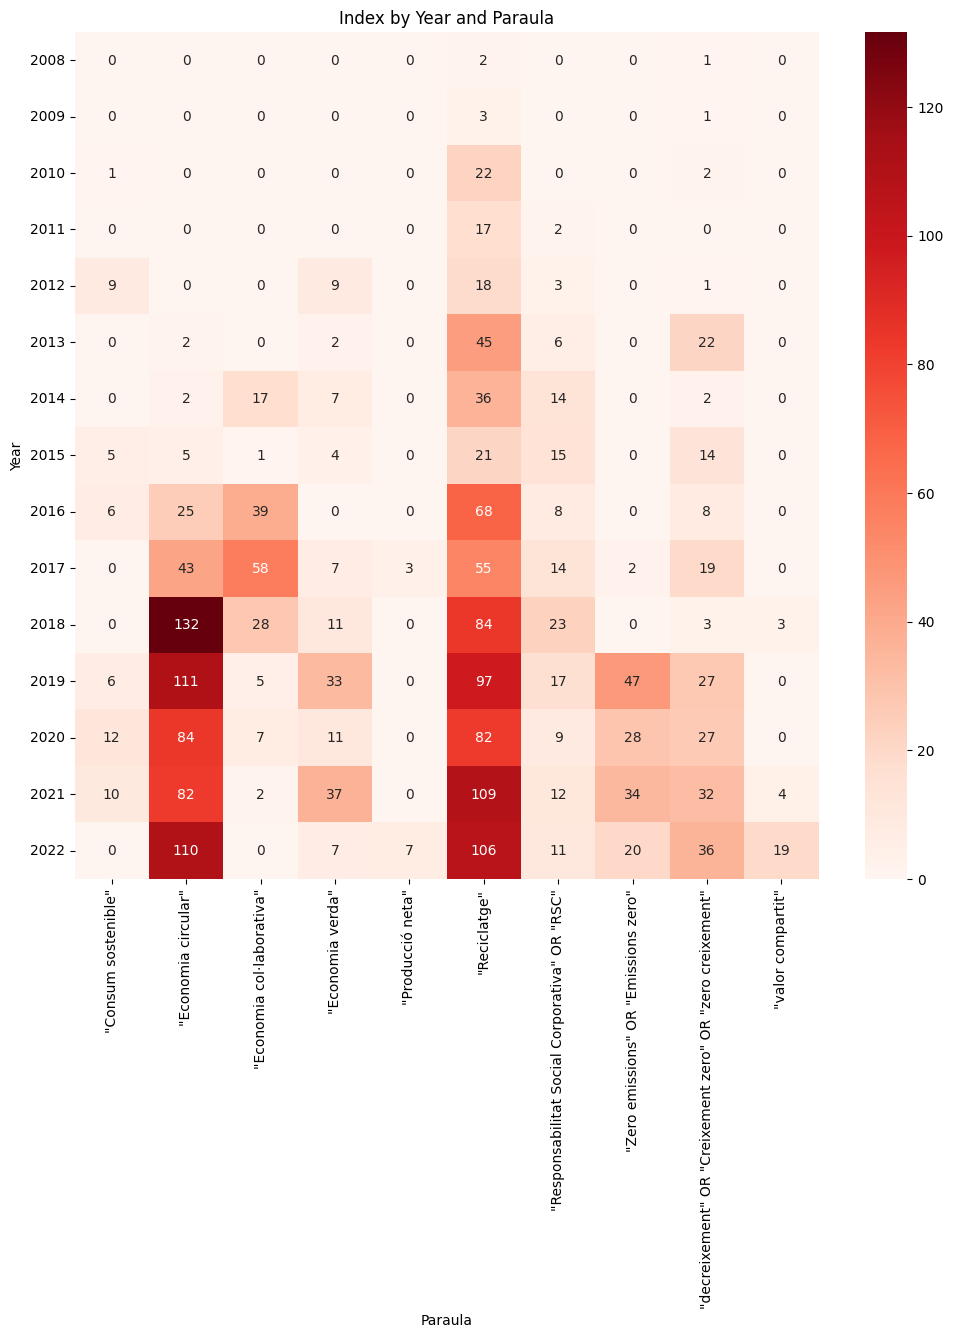

In [25]:
#@title Evolució del nombre de Twits Index en cada paraula per any

plt.figure(figsize=(12,7))
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0.1, 1, len(np.unique(T['Paraula']))))
bot = T.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()

bot -= bot
zero = bot.copy()

for i, paraula in enumerate(list(T['Paraula'].value_counts().sort_values().keys())):
    T_p = T[T['Paraula']==paraula]
    year = (zero + T_p.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()).fillna(0)
    year.plot(kind='bar',color=colors[i],label=paraula,bottom=bot)
    bot += year
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.xticks(np.arange(15), np.arange(2008,2023),rotation=30)
plt.show()

pivot = pd.pivot_table(T, index=pd.Grouper(key='Date', freq='Y'), columns='Paraula', values='Index', aggfunc=np.sum).fillna(0)

plt.figure(figsize=(12, 11))
sns.heatmap(pivot, cmap='Reds', annot=True, fmt='.0f')
plt.title('Index by Year and Paraula')
plt.xlabel('Paraula')
plt.ylabel('Year')
plt.gca().yaxis.set_ticklabels(pivot.index.strftime('%Y'))
plt.show()

# display(pivot)

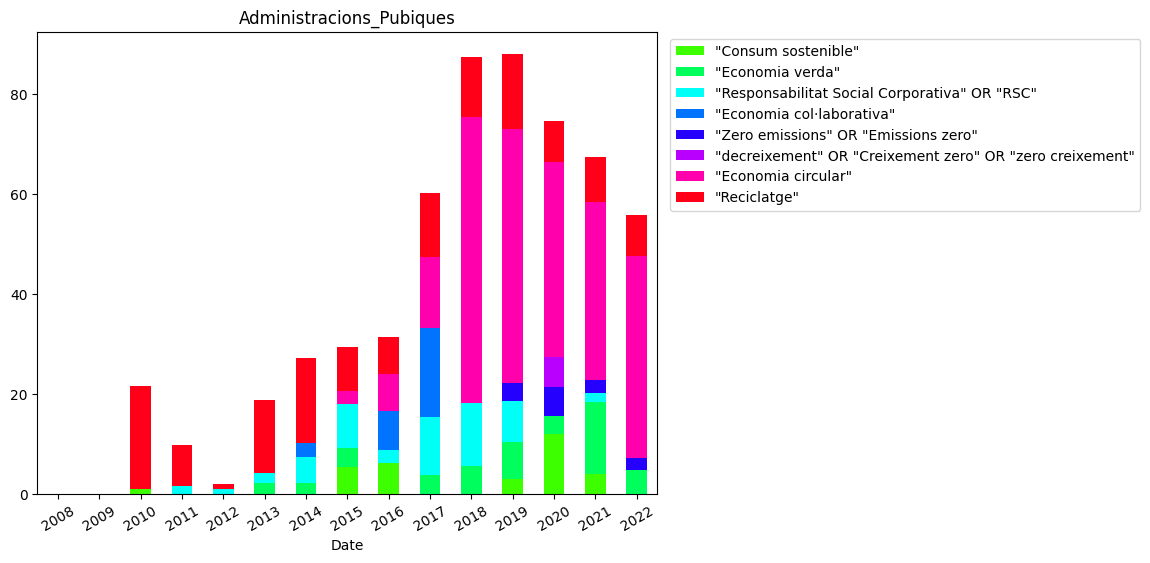

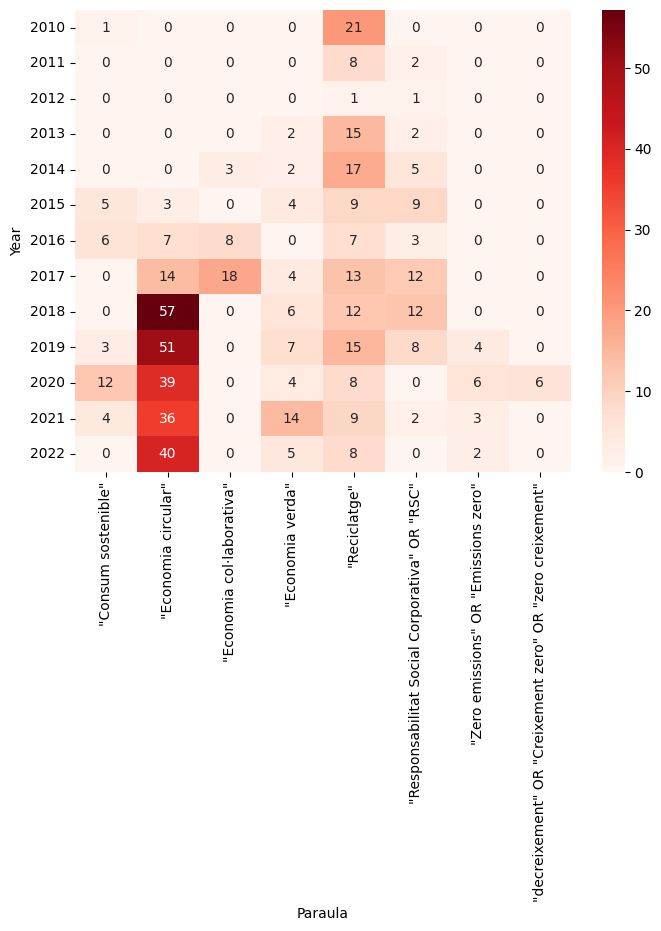

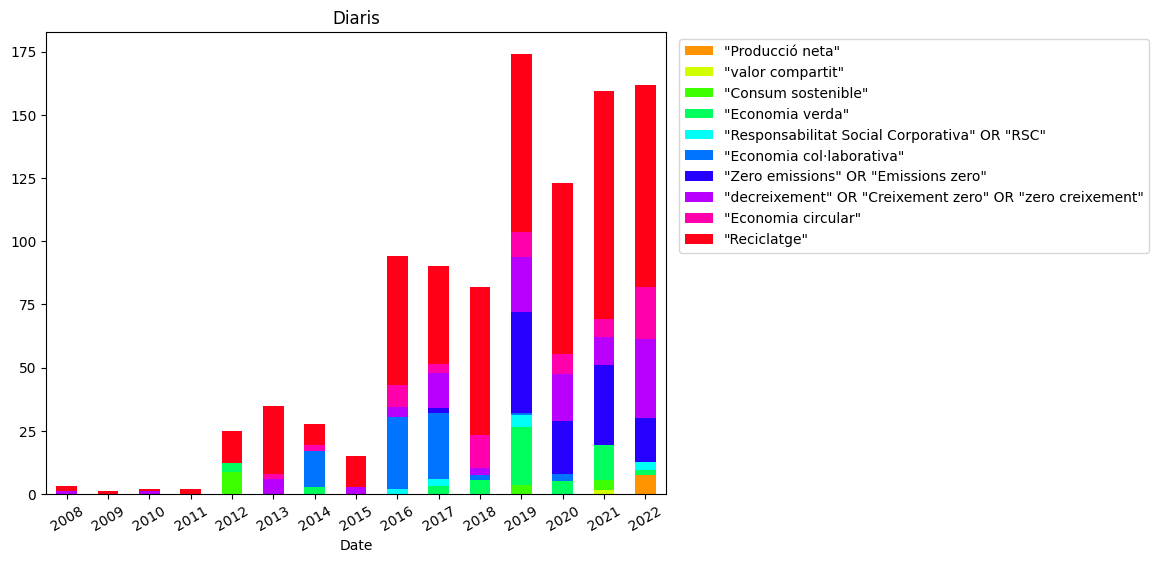

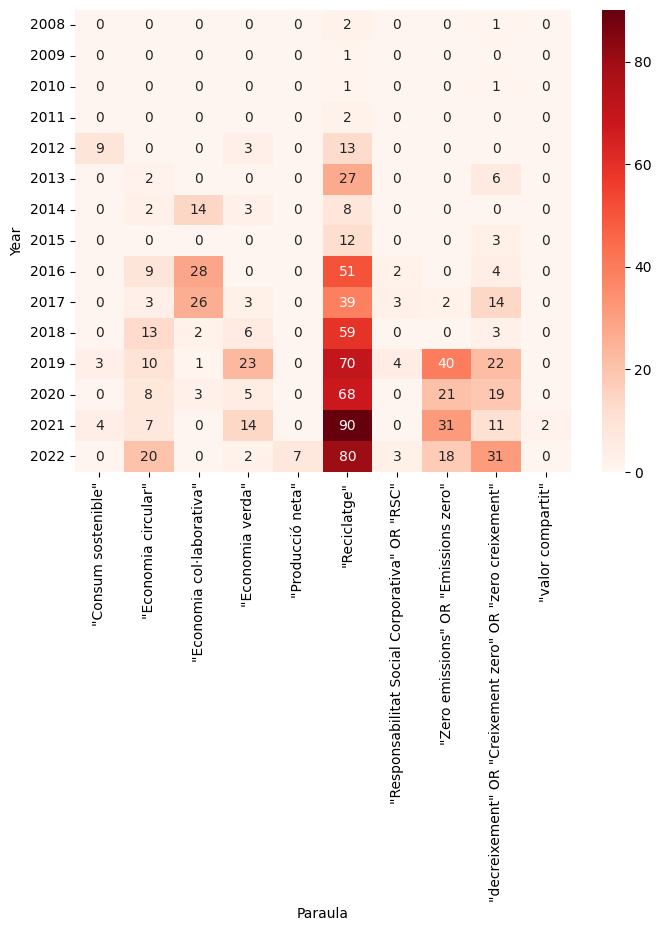

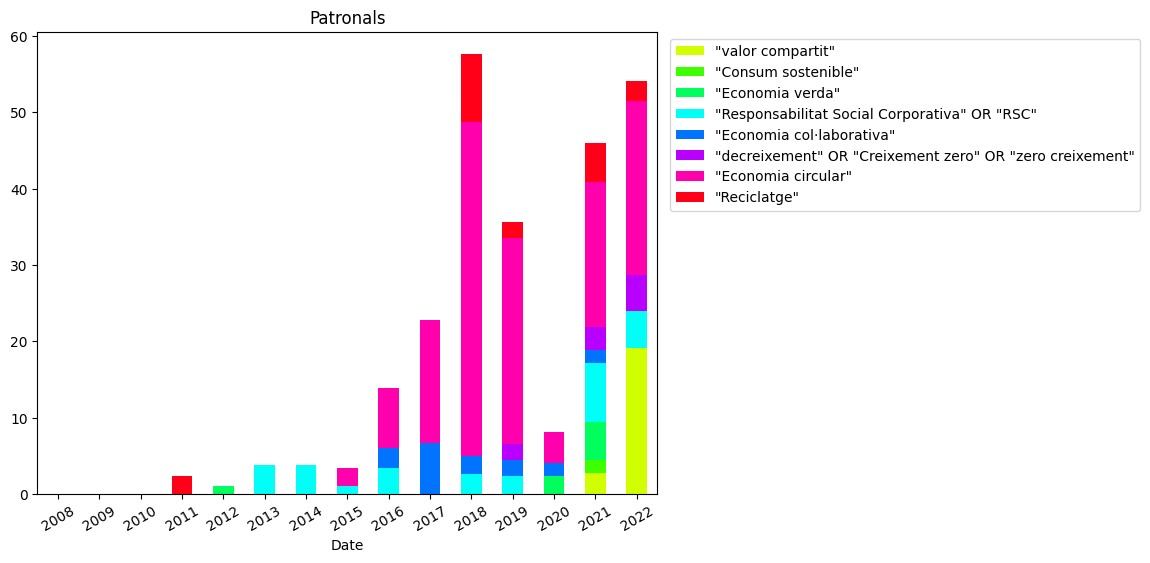

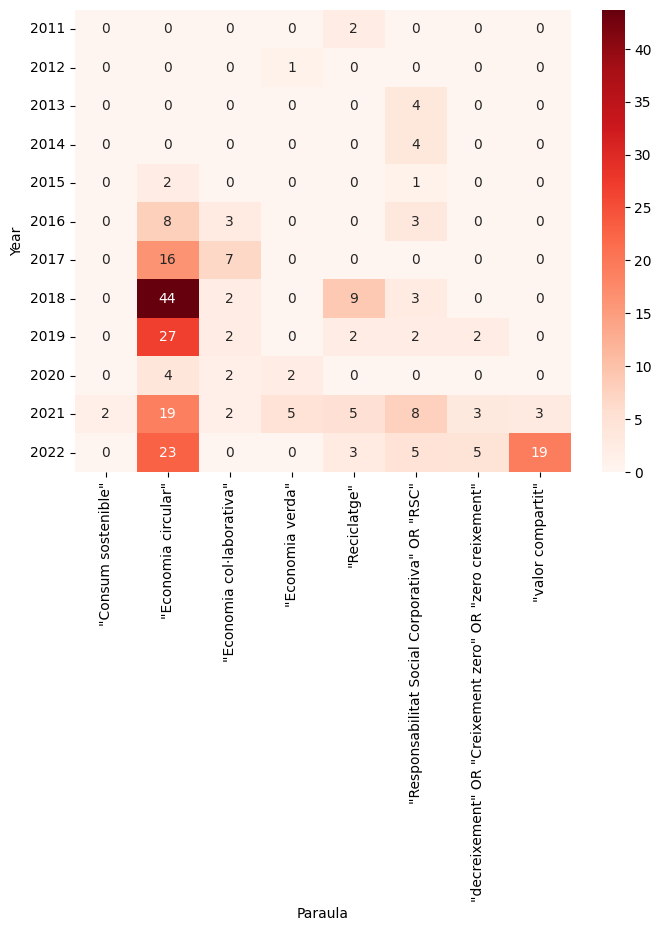

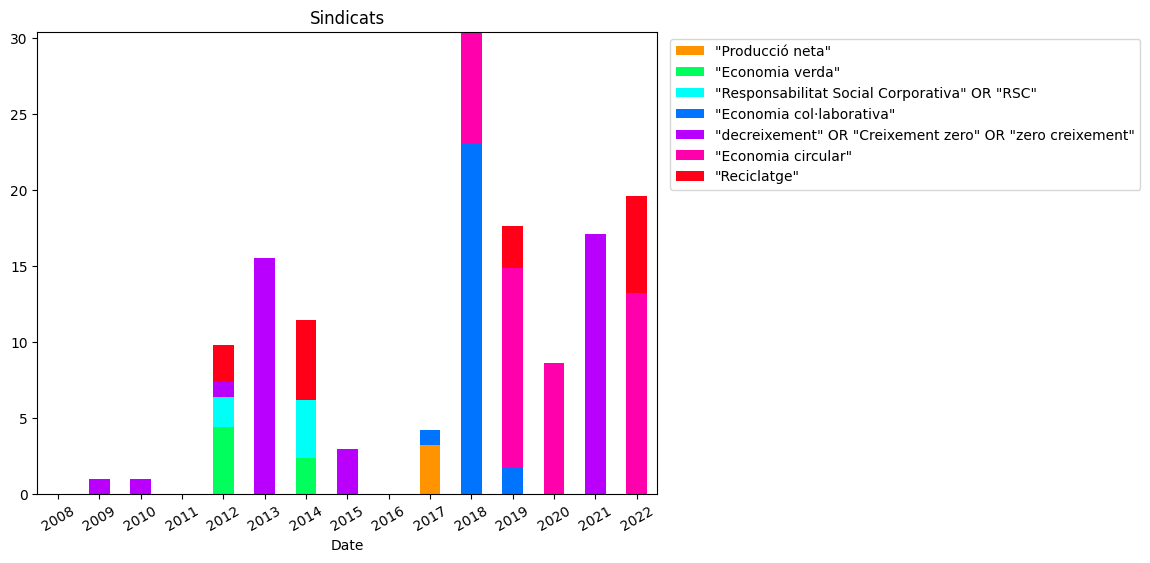

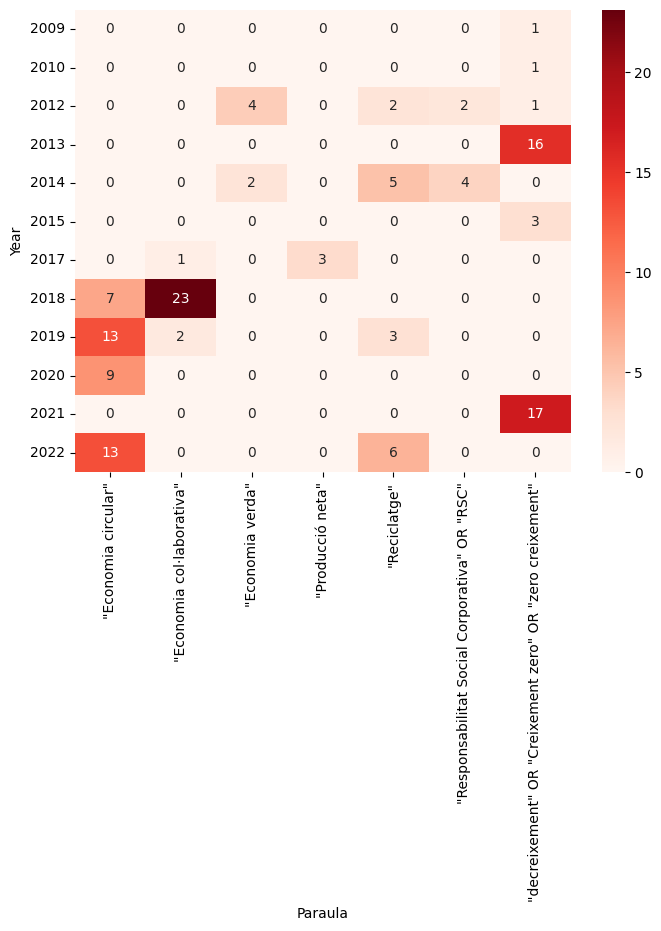

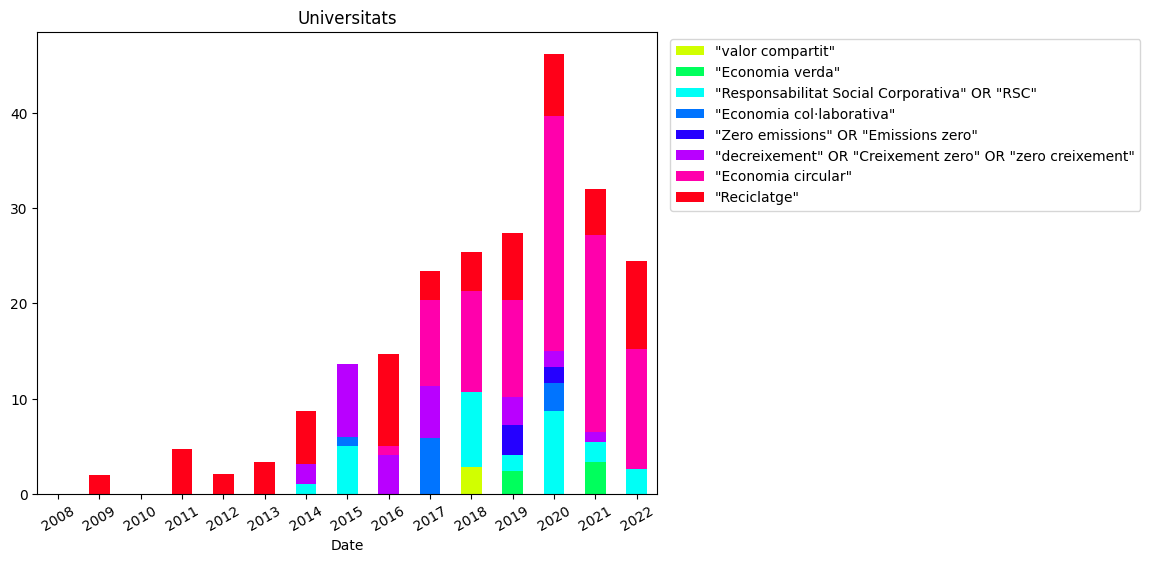

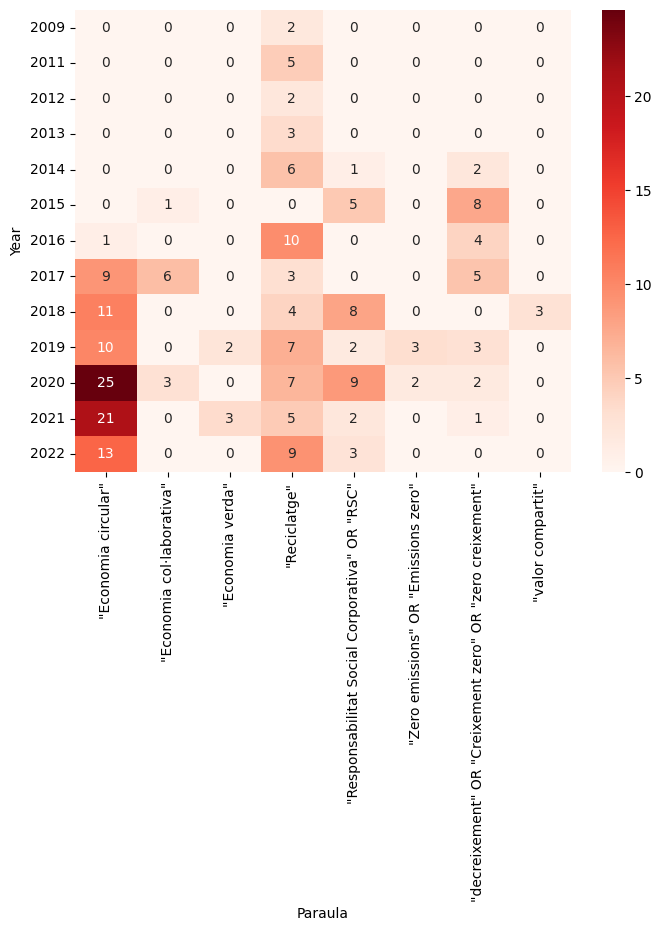

In [26]:
#@title Mateix gràfic separat per grups
# plt.figure(figsize=(8,32))
for j,group in enumerate(np.unique(T['Grup'])):
    # ax = plt.subplot(5,1,j+1)
    plt.figure(figsize=(8, 6))
    bot = zero.copy()
    Tg = T[T['Grup']==group]
    for i, paraula in enumerate(list(T['Paraula'].value_counts().sort_values().keys())):
        if(np.sum(Tg['Paraula']==paraula)>0):
            Tp = Tg[Tg['Paraula']==paraula]
            year = (zero + Tp.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()).fillna(0)
            year.plot(kind='bar',color=colors[i],label=paraula,bottom=bot)
            bot += year
            plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    plt.xticks(np.arange(15), np.arange(2008,2023),rotation=30)
    plt.title(group)
    # ax.set_xlabel('')
    plt.show()

    pivot = pd.pivot_table(Tg, index=pd.Grouper(key='Date', freq='Y'), columns='Paraula', values='Index', aggfunc=np.sum).fillna(0)

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, cmap='Reds', annot=True, fmt='.0f')
    plt.title('')
    plt.xlabel('Paraula')
    plt.ylabel('Year')
    plt.gca().yaxis.set_ticklabels(pivot.index.strftime('%Y'))
    plt.show()

    # display(pivot)

# Anàlisi de tots els twits en català que continguin les paraules


In [27]:
#@title <h5> fix some variable
T_All['Date'] = pd.to_datetime(T_All['Date'],errors='coerce')

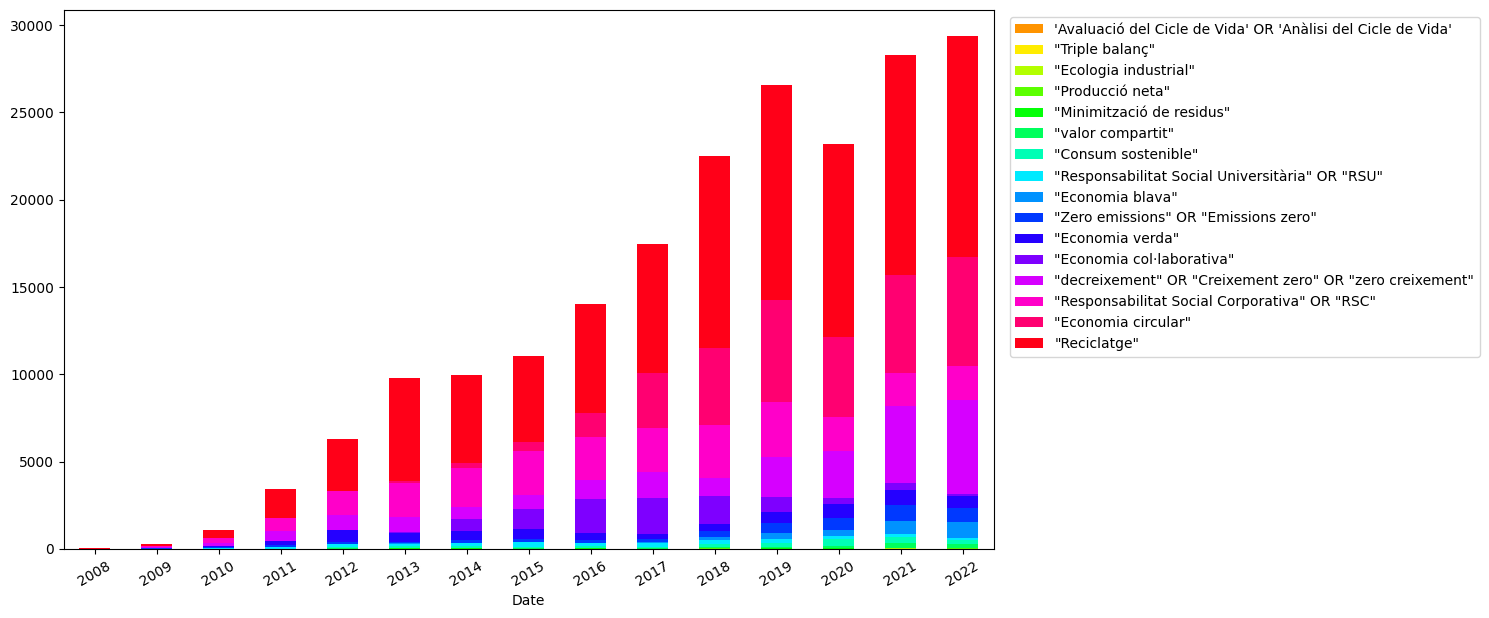

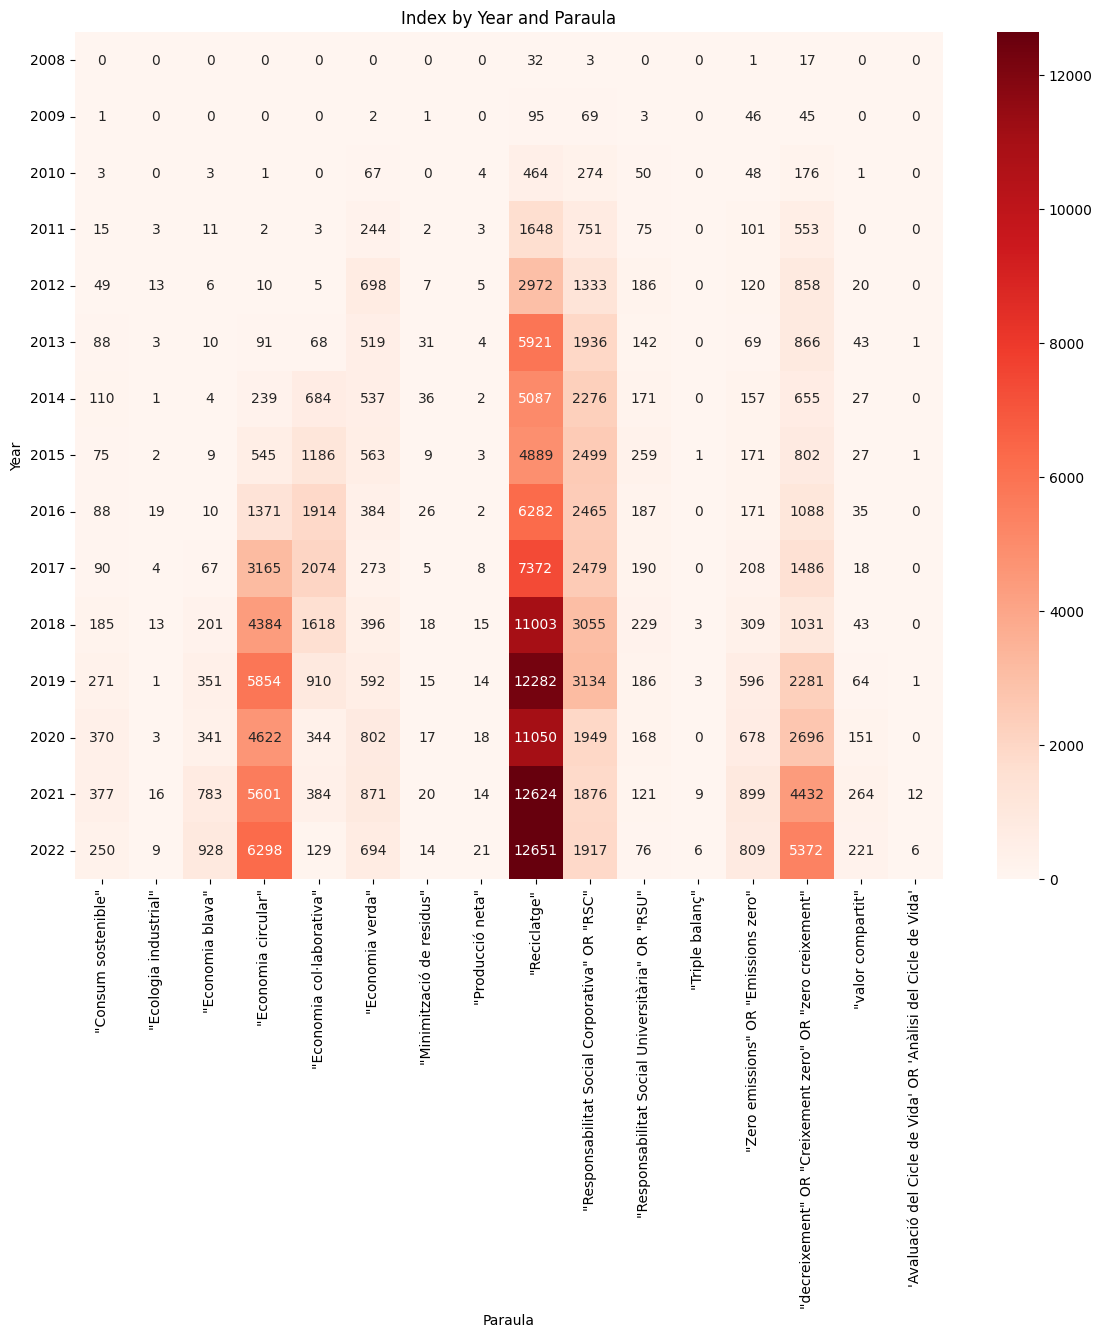

In [28]:
#@title Evolució del nombre de Twits Index en cada paraula per any
plt.figure(figsize=(12,7))
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0.1, 1, len(np.unique(T_All['Paraula']))))
bot = T_All.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()
bot -= bot
zero = bot.copy()

for i, paraula in enumerate(list(T_All['Paraula'].value_counts().sort_values().keys())):
    T_p = T_All[T_All['Paraula']==paraula]
    year = (zero + T_p.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()).fillna(0)
    year.plot(kind='bar',color=colors[i],label=paraula,bottom=bot)
    bot += year
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.xticks(np.arange(15), np.arange(2008,2023),rotation=30)
plt.show()


pivot = pd.pivot_table(T_All, index=pd.Grouper(key='Date', freq='Y'), columns='Paraula', values='Index', aggfunc=np.sum).fillna(0)


plt.figure(figsize=(14, 11))
sns.heatmap(pivot, cmap='Reds', annot=True, fmt='.0f')
plt.title('Index by Year and Paraula')
plt.xlabel('Paraula')
plt.ylabel('Year')
plt.gca().yaxis.set_ticklabels(pivot.index.strftime('%Y'))
plt.show()


# display(pivot)

In [29]:
#@title Percentatge de twits amb localització

print('Percentatge de twits amb localització : {:.3} %'.format(sum(~pd.isna(T_All['Coords']))/len(T_All['Coords'])*100))

print("Percentatge d'usuaris únics representats : {:.3} %".format(len(T_All[~pd.isna(T_All['Coords'])].User.unique())/len(T_All.User.unique())*100))

Percentatge de twits amb localització : 3.19 %
Percentatge d'usuaris únics representats : 6.34 %


In [30]:
#@title <h5>Extreure latitud i longitud
def extreure(coordenada,xy='long'):
    if(type(coordenada)!=str):
        return coordenada
    lon, lat = coordenada.replace("Coordinates(", "").replace(")", "").replace("longitude=", "").replace("latitude=", "").split(",")
    if(xy=='long'):
        return float(lon)
    return float(lat)

T_All["long"] = T_All["Coords"].apply(extreure,xy = 'long')
T_All["lat"] = T_All["Coords"].apply(extreure,xy = 'lat')

T_mapa = T_All[~pd.isna(T_All['Coords'])][['long','lat']].drop_duplicates()

In [31]:
#@title <h6>old map
# import plotly.express as px
# import pandas as pd

# mapbox_token = "pk.eyJ1IjoiYXp1YmFyY28iLCJhIjoiY2s0OHRtbDNsMGI5YTNrcHJueWV3N20zdCJ9.qpTrQEyiBNskROz38Ggc3Q" 

# fig = px.scatter_mapbox(T_All,
#                         lat="lat",
#                         lon="long",
#                         zoom=4,
#                         size='Index')

# fig.update_layout(mapbox_accesstoken=mapbox_token)
# fig.write_html("mapa.html")
# fig.show()


In [32]:
#@title Definir variables mapes
comarques = gpd.read_file('https://github.com/AlbertRoca29/EconomiaCircular/blob/main/plantilles_mapes_shp/comarques.zip?raw=true!comarques.shp')
provincies = gpd.read_file('https://github.com/AlbertRoca29/EconomiaCircular/blob/main/plantilles_mapes_shp/provincies.zip?raw=true!provincies.shp')
municipis = gpd.read_file('https://github.com/AlbertRoca29/EconomiaCircular/blob/main/plantilles_mapes_shp/municipis.zip?raw=true!municipis.shp')

paisos_catalans = ["Alacant/Alicante", "Castelló/Castellón", "València/Valencia","Barcelona","Illes Balears","Girona", "Tarragona","Lleida"]
Area_metro = [
"la Palma de Cervelló",
"Badia del Vallès",
"Viladecans",
"Torrelles de Llobregat",
"Tiana",
"Cerdanyola del Vallès",
"Sant Vicenç dels Horts",
"Barberà del Vallès",
"Santa Coloma de Gramenet",
"Santa Coloma de Cervelló",
"Sant Just Desvern",
"Sant Joan Despí",
"Sant Feliu de Llobregat",
"Sant Cugat del Vallès",
"Sant Climent de Llobregat",
"Sant Boi de Llobregat",
"Sant Andreu de la Barca",
"Sant Adrià de Besòs",
"Ripollet",
"el Prat de Llobregat",
"el Papiol",
"Pallejà",
"Montgat",
"Montcada i Reixac",
"Molins de Rei",
"l'Hospitalet de Llobregat",
"Gavà",
"Esplugues de Llobregat",
"Cornellà de Llobregat",
"Corbera de Llobregat",
"Cervelló",
"Castelldefels",
"Castellbisbal",
"Begues",
"Barcelona",
"Badalona"
]

provincies = provincies[provincies['NAMEUNIT'].isin(paisos_catalans)]
areaBCN = municipis[municipis['NOM_MUNI'].isin(Area_metro)]
geometry = [Point(xy) for xy in zip(T_mapa['long'], T_mapa['lat'])]

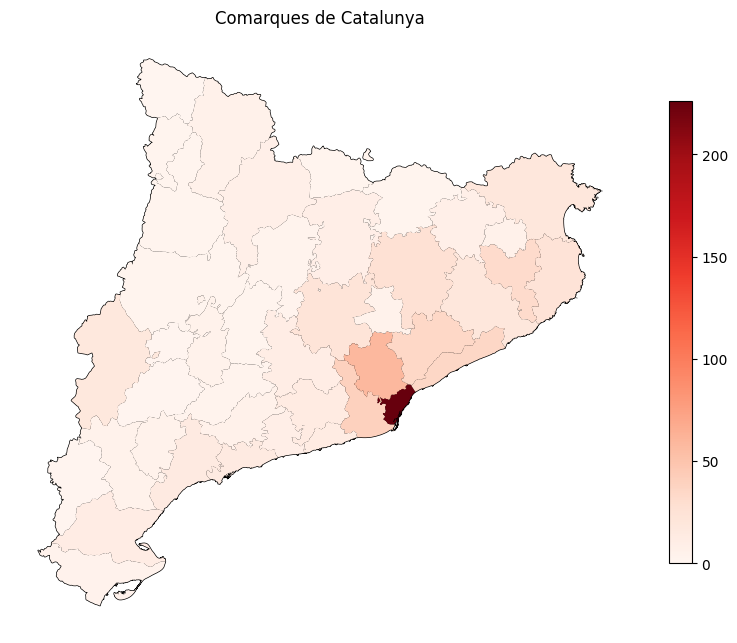

In [33]:
#@title Mapa Comarques
points = gpd.GeoDataFrame(T_mapa, geometry=geometry, crs='EPSG:4326').to_crs(comarques.crs)

sums = gpd.sjoin(comarques, points, how='left', predicate='contains').groupby('NOMCOMAR')['lat'].count()


fig, ax = plt.subplots(figsize=(10, 10))
comarques.plot(ax=ax, facecolor='lightgray', edgecolor='black')
comarques.join(sums, on='NOMCOMAR').plot(column='lat', cmap='Reds', ax=ax, legend=True,legend_kwds={'shrink': 0.6})
ax.set_axis_off()

plt.title('Comarques de Catalunya')

plt.show()

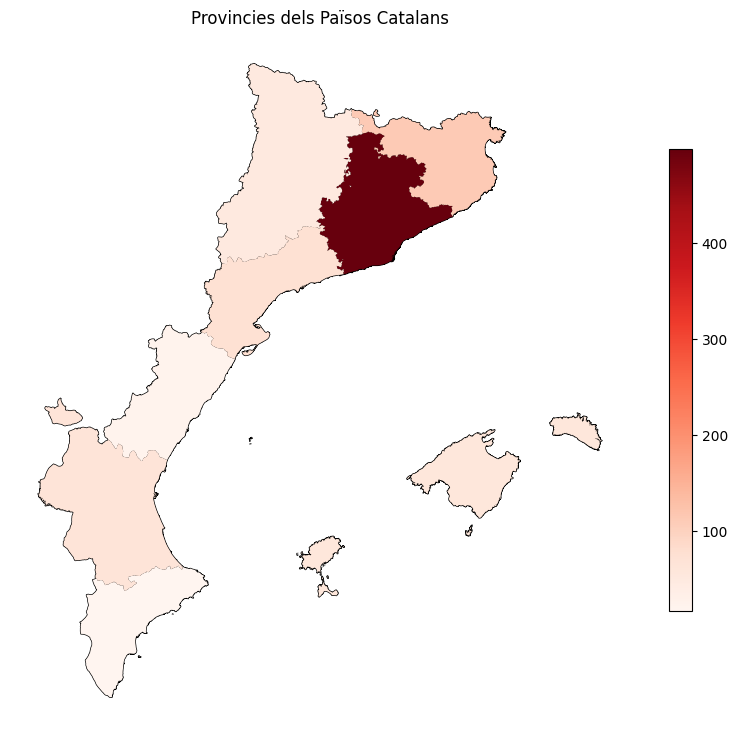

In [34]:
#@title Mapa Provincies Països Catalans
points = gpd.GeoDataFrame(T_mapa, geometry=geometry, crs='EPSG:4326').to_crs(provincies.crs)

sums = gpd.sjoin(provincies, points, how='left', predicate='contains').groupby('NAMEUNIT')['lat'].count()


fig, ax = plt.subplots(figsize=(10, 10))
provincies.plot(ax=ax, facecolor='lightgray', edgecolor='black')
provincies.join(sums, on='NAMEUNIT').plot(column='lat', cmap='Reds', ax=ax, legend=True,legend_kwds={'shrink': 0.6})
ax.set_axis_off()


plt.title('Provincies dels Països Catalans')

plt.show()

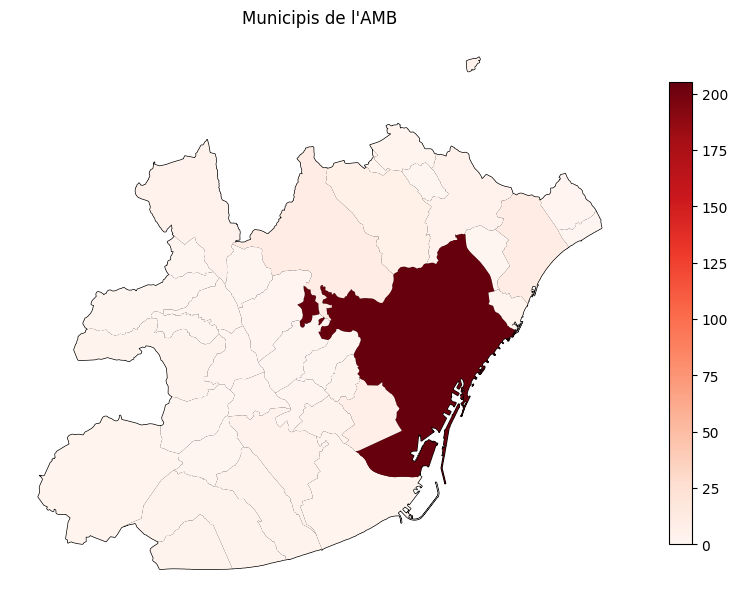

In [35]:
#@title Mapa municipis de l'àrea metropolitana de Barcelona
points = gpd.GeoDataFrame(T_mapa, geometry=geometry, crs='EPSG:4326').to_crs(areaBCN.crs)

sums = gpd.sjoin(areaBCN, points, how='left', predicate='contains').groupby('NOM_MUNI')['lat'].count()


fig, ax = plt.subplots(figsize=(10, 10))
areaBCN.plot(ax=ax, facecolor='lightgray', edgecolor='black')
areaBCN.join(sums, on='NOM_MUNI').plot(column='lat', cmap='Reds', ax=ax, legend=True,legend_kwds={'shrink': 0.6})
ax.set_axis_off()


plt.title("Municipis de l'AMB")

plt.show()